In [176]:
import argparse
import os
import pathlib
import openai
import json
import base64
import re
import random
from tenacity import retry, retry_if_exception_type, stop_after_attempt

In [177]:
class PromptTemplate:
    def __init__(self, resolution):
        self.resolution = resolution

    def __call__(self, imgs):
        raise NotImplementedError
    
    def parse_output(self, output):
        raise NotImplementedError

 ## Alex's short trajectory analysis

In [178]:
START_END_PROMPT = """
The following pictures are from an RL environment. It's a multitask benchmark where a robot must move blocks of different colours and shapes in a 2D square to achieve different goals. The goals are to be inferred from demonstrations, and are easy to grasp for humans.
The first picture is the starting state of the environment. The second picture is the goal state of the environment, where the objective was achieved. There are three possible kind of objects in this environment. The grey circular object labelled R is a robot with two arms that can move around and move blocks (if there are any) to achieve the objective. The robot is always present. There can be movable blocks, which have different shapes and colours, they all have a solid outline. The possible shapes are circle, square and star, no other shapes exist. The possible colours are blue, pink, and green. Blocks do not disappear. Each block is labeled by a number starting from B1, to B2, to B3, etc. to help you keep track of them. There can also be special areas in the environment, these are light coloured with dashed outlines. Special areas can only be rectangular. They are labelled SA1, SA2, etc. to help you distinguish them from movable blocks. The robot can move inside the special areas and place blocks (if there are any) inside them. There may or may not be any special areas. There is a 3x3 grid with rows A,B,C and columns 1,2,3 to help you refer to the position of the objects, but it is only a visual help for you. The objective does not include any reference to the grid. Your job is to be an expert on this environment and correctly identify the objective based on the start and end states. The goals should be as general and high-level as possible. Think out loud step-by-step by
1, identify the robot on the first picture. It is always present, has a number and is grey circular with two arms. It is labeled R.
2, identify the special areas on the first picture if there are any. These are rectangles and have labels with SA and a number starting from 1. Name their colour too.
3, identify the movable blocks if there are any. These are the numbered shapes labeled B with a number starting from 1. Name their shape and colour.
5, describing the position of the objects in the first picture by referring to the grid. For movable blocks, state explicitly whether they are in a special area or not. For special areas, state whether they contain blocks or not.
6, naming the objects in the second picture. These should be the same as in the first picture with the same numeric labels, objects do not disappear and new ones do not appear. Do not refer back to the first picture when doing this.
7, describing their position in the second picture. Do not refer back to the first picture when doing this. Don't compare and say what changed from the first picture, just describe the position of the objects. Don’t use words like “changed”, “remains”, “still” or any words that would refer back to the first picture.
8, comparing the image descriptions. Do not compare the pictures directly.
Output the goal as a short, descriptive sentence on a new line after the words "GOAL:" Do not mention the 3x3 grid in your final answer.
"""

In [179]:
TWO_FRAME_SHORT_GOAL_PROMPT = """
The following pictures are from an RL environment. It's a multitask benchmark where a robot must move blocks of different colours and shapes in a 2D square to achieve different goals. The goals are to be inferred from demonstrations, and are easy to grasp for humans. You are given two frames from a part of the trajectory of the agent in the process of completing the goal. There are three possible kind of objects in this environment. The grey circular object labelled R is a robot with two arms that can move around and move blocks (if there are any) to achieve the objective. The robot is always present. There can be movable blocks, which have different shapes and colours, they all have a solid outline. The possible shapes are circle, square and star, no other shapes exist. The possible colours are blue, pink, and green. Blocks do not disappear. Each block is labeled by a number starting from B1, to B2, to B3, etc. to help you keep track of them. There can also be special areas in the environment, these are light coloured with dashed outlines. Special areas can only be rectangular. They are labelled SA1, SA2, etc. to help you distinguish them from movable blocks. The robot can move inside the special areas and place blocks (if there are any) inside them. There may or may not be any special areas. There is a 3x3 grid with rows A,B,C and columns 1,2,3 to help you refer to the position of the objects, but it is only a visual help for you. The objective does not include any reference to the grid. Your job is to be an expert on this environment and by looking at the given two trajectory frames, identify what subgoal the agent was following between the two frames. Think out loud step-by-step by
1, identify the robot on the first picture. It is always present, has a number and is grey circular with two arms. It is labeled R.
2, identify the special areas on the first picture if there are any. These are rectangles and have labels with SA and a number starting from 1. Name their colour too.
3, identify the movable blocks if there are any. These are the numbered shapes labeled B with a number starting from 1. Name their shape and colour.
5, describing the position of the objects in the first picture by referring to the grid. For movable blocks, state explicitly whether they are in a special area or not. For special areas, state whether they contain blocks or not.
6, naming the objects in the second picture. These should be the same as in the first picture with the same numeric labels, objects do not disappear and new ones do not appear. Do not refer back to the first picture when doing this.
7, describing their position in the second picture. Do not refer back to the first picture when doing this. Don't compare and say what changed from the first picture, just describe the position of the objects. Don’t use words like “changed”, “remains”, “still” or any words that would refer back to the first picture.
8, comparing the image descriptions. Do not compare the pictures directly.
Output the agent's subgoal as a short, descriptive sentence on a new line after the words "SUBGOAL:" Do not mention the 3x3 grid in your final answer,  for example instead of "move to B3" describe parts of the area as, as "move to middle", "move to top left", "move to block B3" etc.  Don't be vague, for example instead of  "move to a new location", be specific and say "move to the bottom of the arena".
"""

In [180]:
MULTIPLE_SEQUENTIAL_SUBGOALS_PROMPT = """
The following pictures are from an RL environment. It's a multitask benchmark where a robot must move blocks of different colours and shapes in a 2D square to achieve different goals. The goals are to be inferred from demonstrations, and are easy to grasp for humans. You are given multiple frames from a part of the trajectory of the agent in the process of completing the goal. There are three possible kind of objects in this environment. The grey circular object labelled R is a robot with two arms that can move around and move blocks (if there are any) to achieve the objective. The robot is always present. There can be movable blocks, which have different shapes and colours, they all have a solid outline. The possible shapes are circle, square and star, no other shapes exist. The possible colours are blue, pink, and green. Blocks do not disappear. Each block is labeled by a number starting from B1, to B2, to B3, etc. to help you keep track of them. There can also be special areas in the environment, these are light coloured with dashed outlines. Special areas can only be rectangular. They are labelled SA1, SA2, etc. to help you distinguish them from movable blocks. The robot can move inside the special areas and place blocks (if there are any) inside them. There may or may not be any special areas. There is a 3x3 grid with rows A,B,C and columns 1,2,3 to help you refer to the position of the objects, but it is only a visual help for you. The objective does not include any reference to the grid. Your job is to be an expert on this environment and by looking at the given sequency of trajectory frames, identify what subgoal the agent was following between the frames. Give a list of subgoals the agent was pursuing between each subsequent frames. Think out loud step-by-step by
1, identify the robot on the first picture. It is always present, has a number and is grey circular with two arms. It is labeled R.
2, identify the special areas on the first picture if there are any. These are rectangles and have labels with SA and a number starting from 1. Name their colour too.
3, identify the movable blocks if there are any. These are the numbered shapes labeled B with a number starting from 1. Name their shape and colour.
4, describing the position of the objects in the first picture by referring to the grid. For movable blocks, state explicitly whether they are in a special area or not. For special areas, state whether they contain blocks or not.
5, Go through the subsequent frames and identify the robot, special areas and movable blocks in each frame. Do not refer back to the first picture when doing this. Describe the position of the objects in each frame by referring to the grid. For movable blocks, state explicitly whether they are in a special area or not. For special areas, state whether they contain blocks or not.
6,  By comparing the image descriptions, identify the subgoals the agent was following. Do not compare the pictures directly.
Output the agent's subgoals as a short, descriptive list of sentences on a new line after the words "SUBGOALS:" They should be in the format [frame 1-2: subgoal1, frame 2-3: subgoal2, ...]  Do not mention the 3x3 grid in your final answer,  for example instead of "move to B3" describe parts of the area as, as "move to middle", "move to top left", "move to block B3" etc.  Don't be vague, for example instead of  "move to a new location", be specific and say "move to the bottom of the arena".
7, Conclude what the overall subgoal of the agent was across the whole trajectory. Output your answer on a newline as "GOAL:". Do not mention the 3x3 grid in your final answer,  for example instead of "move to B3" describe parts of the area as, as "move to middle", "move to top left", "move to block B3" etc.  Don't be vague, for example instead of  "move to a new location", be specific and say "move to the bottom of the arena".
"""


In [181]:
MULTIPLE_FRAME_SHORT_GOAL_PROMPT = """
The following pictures are from an RL environment. It's a multitask benchmark where a robot must move blocks of different colours and shapes in a 2D square to achieve different goals. The goals are to be inferred from demonstrations, and are easy to grasp for humans. You are given multiple frames from a part of the trajectory of the agent in the process of completing the goal. There are three possible kind of objects in this environment. The grey circular object labelled R is a robot with two arms that can move around and move blocks (if there are any) to achieve the objective. The robot is always present. There can be movable blocks, which have different shapes and colours, they all have a solid outline. The possible shapes are circle, square and star, no other shapes exist. The possible colours are blue, pink, and green. Blocks do not disappear. Each block is labeled by a number starting from B1, to B2, to B3, etc. to help you keep track of them. There can also be special areas in the environment, these are light coloured with dashed outlines. Special areas can only be rectangular. They are labelled SA1, SA2, etc. to help you distinguish them from movable blocks. The robot can move inside the special areas and place blocks (if there are any) inside them. There may or may not be any special areas. There is a 3x3 grid with rows A,B,C and columns 1,2,3 to help you refer to the position of the objects, but it is only a visual help for you. The objective does not include any reference to the grid. Your job is to be an expert on this environment and by looking at the given trajectory frames, identify what subgoal the agent was following based on the given frames. Think out loud step-by-step by
1, identify the robot on the first picture. It is always present, has a number and is grey circular with two arms. It is labeled R.
2, identify the special areas on the first picture if there are any. These are rectangles and have labels with SA and a number starting from 1. Name their colour too.
3, identify the movable blocks if there are any. These are the numbered shapes labeled B with a number starting from 1. Name their shape and colour.
4, describing the position of the objects in the first picture by referring to the grid. For movable blocks, state explicitly whether they are in a special area or not. For special areas, state whether they contain blocks or not.
5, Go through the subsequent frames and identify the robot, special areas and movable blocks in each frame. Do not refer back to the first picture when doing this. Describe the position of the objects in each frame by referring to the grid. For movable blocks, state explicitly whether they are in a special area or not. For special areas, state whether they contain blocks or not.
6, By comparing the image descriptions, identify the subgoal the agent was following. Do not compare the pictures directly. Output the agent's subgoal as a short, descriptive sentence on a new line after the words "SUBGOAL:" Do not mention the 3x3 grid in your final answer,  for example instead of "move to B3" describe parts of the area as, as "move to middle", "move to top left", "move to block B3" etc.  Don't be vague, for example instead of  "move to a new location", be specific and say "move to the bottom of the arena".
"""

In [182]:
class StartEndTemplate(PromptTemplate):
    
    def __init__(self, resolution):
        super().__init__(resolution)
        self.prompt = START_END_PROMPT
        
    
    def __call__(self, imgs):
        assert len(imgs) == 2, "Must provide two images"
        before_img, after_img = imgs
        return [
            {
                "type": "text",
                "text": self.prompt,
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{before_img}",
                    "detail": self.resolution,
                },
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{after_img}",
                    "detail": self.resolution,
                },
            },
        ]

    def parse_output(self, text):
        # Find any lines that start with "GOAL:"
        goal_lines = [line for line in text.split("\n") if line.startswith("GOAL:")]
        # Remove the "GOAL:" prefix
        goals = [line.replace("GOAL:", "") for line in goal_lines]
        return {'goals': goals}



In [183]:
class TwoFrameShortGoalTemplate(PromptTemplate):
    
    def __init__(self, resolution):
        super().__init__(resolution)
        self.prompt = TWO_FRAME_SHORT_GOAL_PROMPT
        
    
    def __call__(self,imgs):
        assert len(imgs) == 2, "Must provide two images"
        before_img, after_img = imgs
        return [
            {
                "type": "text",
                "text": self.prompt,
            },
            {
                "type": "text",
                "text": f"Frame 1:",
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{before_img}",
                    "detail": self.resolution,
                },
            },
            {
                "type": "text",
                "text": f"Frame 2:",
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{after_img}",
                    "detail": self.resolution,
                },
            },
        ]

    def parse_output(self, text):
        # Find any lines that start with "GOAL:"
        goal_lines = [line for line in text.split("\n") if line.startswith("SUBGOAL:")]
        # Remove the "GOAL:" prefix
        goals = [line.replace("SUBGOAL:", "") for line in goal_lines]
        return {'subgoals': goals}


In [184]:
class MultipleSequentialSubgoals(PromptTemplate):
    
    def __init__(self, resolution):
        super().__init__(resolution)
        self.prompt = MULTIPLE_SEQUENTIAL_SUBGOALS_PROMPT
        
    def get_call_text(self, imgs):
        nested_list = [
            [ {
                "type": "text",
                "text": f"Frame {idx}:",
            },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{img}",
                    "detail": self.resolution,
                },
            } ]
            for idx,img in enumerate(imgs)]
        # unnest the list
        return [item for sublist in nested_list for item in sublist]

    
    def __call__(self,imgs):
        return [
            {
                "type": "text",
                "text": self.prompt,
            }] + self.get_call_text(imgs)
        

    def parse_output(self, text):
        # "Keep everything after subgoals"
        return {'subgoals': text.split("SUBGOALS:")[1]}


In [185]:
class MultipleFrameShortGoalTemplate(PromptTemplate):
    
    def __init__(self, resolution):
        super().__init__(resolution)
        self.prompt = MULTIPLE_FRAME_SHORT_GOAL_PROMPT
        
    def get_call_text(self, imgs):
        nested_list = [
            [ {
                "type": "text",
                "text": f"Frame {idx}:",
            },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{img}",
                    "detail": self.resolution,
                },
            } ]
            for idx,img in enumerate(imgs)]
        # unnest the list
        return [item for sublist in nested_list for item in sublist]

    
    def __call__(self,imgs):
        return [
            {
                "type": "text",
                "text": self.prompt,
            }] + self.get_call_text(imgs)
        

    def parse_output(self, text):
        goal_lines = [line for line in text.split("\n") if line.startswith("SUBGOAL:")]
        # Remove the "GOAL:" prefix
        goals = [line.replace("SUBGOAL:", "") for line in goal_lines]
        return {'subgoals': goals}


In [186]:
PROMPT_TEMPLATES = {
    "start_end": StartEndTemplate,
    "two_frame_short_goal": TwoFrameShortGoalTemplate,
    "multiple_sequential_subgoals": MultipleSequentialSubgoals,
    "multiple_frame_short_goal": MultipleFrameShortGoalTemplate,

    
}

In [187]:
@retry(retry=retry_if_exception_type(openai.RateLimitError), stop=stop_after_attempt(5))
def call_vlm(message_content, temperature, max_tokens, cache):
    client = openai.OpenAI()
    vlm_args = {
        "model": "gpt-4-vision-preview",
        "messages":[
            {
                "role": "user",
                "content": message_content,
            }
        ],
        "max_tokens":max_tokens,
        "temperature":temperature,
    }
    serialized_args = json.dumps(vlm_args)
    # check if we have a cached result
    if serialized_args in cache:
        print(serialized_args)
        print("Using cached result")
        return cache[serialized_args]
    
    response = client.chat.completions.create(
        **vlm_args
    )
    # TODO: might want to return the whole response, so we can cehck for finish_reason, etc.
    response = response.choices[0].message.content
    cache[serialized_args] = response
    save_cache(cache)
    return response


def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


def load_cache():
    try:
        with open("cache.json", "r") as f:
            return json.load(f)
    except FileNotFoundError:
        return {}

def save_cache(cache):
    with open("cache.json", "w") as f:
        json.dump(cache, f, indent=4)


def query_vlm(imgs, args, output_file, cache):
    
    # Load the images in base64
    encoded_imgs = []
    for img in imgs:
        print(f"Encoding {img}")
        encoded_imgs.append(encode_image(img))

    prompt_template = PROMPT_TEMPLATES[args.prompt_template](args.resolution)
    messages = prompt_template(encoded_imgs)
    llm_completion = call_vlm(messages, temperature=args.temperature, max_tokens=args.max_tokens, cache=cache)
    
    parsed_goals = prompt_template.parse_output(llm_completion)

    out_dict = {
        "messages": messages,
        "llm_completion": llm_completion,
        "parsed_goals": parsed_goals,
    }
    # output_folder = pathlib.Path(args.output_folder)
    # output_file = output_folder / (out_file_name.name + ".json")

    with open(output_file, 'w') as f:
        json.dump(out_dict, f, indent=4)
    print(f"Wrote {output_file}")
    return out_dict

In [188]:
import datetime
def main(traj_folder, output_folder, prompt_template, resolution, images):
    args = argparse.Namespace()
    args.prompt_template = prompt_template
    args.resolution = resolution
    args.temperature = 0.5
    args.max_tokens = 1000
    args.output_folder = output_folder
    args.traj_folder = traj_folder
    args.all_traj_folder = None
    args.num_files = None

    

    cache = load_cache()
    output_folder = pathlib.Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)
    now = datetime.datetime.now()
    time_str = now.strftime('%FT%H:%M:%S')
    file_name = prompt_template +time_str+ ".json"
    out_path = os.path.join(output_folder, file_name)
    print(out_path)
    
    data_folder = pathlib.Path(traj_folder)
    # check that it's a folder that exists
    assert data_folder.is_dir(), f"{data_folder} is not a folder that exists"
    img_paths = []
    for img in images:
        img_paths.append(os.path.join(data_folder, img))
    query_vlm(img_paths, args, out_path, cache)
    print("Done!")

    return out_path

In [189]:
def write_final_answer(template, ground_truth_file, final_answer_dir, ans_files):
    now = datetime.datetime.now()
    time_str = now.strftime('%FT%H:%M:%S')
    file_name = template + time_str+ ".json"
    file_path = os.path.join(final_answer_dir, file_name)

    file_content ={}
    with open(ground_truth_file, 'r') as f:
        truth = json.load(f)
    
    goals =[]
    for gpt_ans in ans_files:
        with open(gpt_ans, 'r') as f:
            gpt_pred = json.load(f)
            print()
            goals.append(gpt_pred["parsed_goals"])


    for i in range(len(ans_files)):
        file_content[i+1] = {}
        file_content[i+1]['answer_file'] = ans_files[i]
        file_content[i+1]['ground_truth'] = truth[str(i+1)]
        file_content[i+1]['predicted'] = goals[i]


    with open(file_path, 'w') as f:
        json.dump(file_content, f, indent=4)

/Users/alexandrasouly/code/chai/magical/frame_pairs/Task2/20-frame-pairs/pair1/two_frame_short_goal/two_frame_short_goal2023-11-21T16:51:31.json
Encoding /Users/alexandrasouly/code/chai/magical/frame_pairs/Task2/20-frame-pairs/pair1/frame-FindDupeTestAllv020231114T10_53_37.pkl.gz-6.png
Encoding /Users/alexandrasouly/code/chai/magical/frame_pairs/Task2/20-frame-pairs/pair1/frame-FindDupeTestAllv020231114T10_53_37.pkl.gz-26.png
{"model": "gpt-4-vision-preview", "messages": [{"role": "user", "content": [{"type": "text", "text": "\nThe following pictures are from an RL environment. It's a multitask benchmark where a robot must move blocks of different colours and shapes in a 2D square to achieve different goals. The goals are to be inferred from demonstrations, and are easy to grasp for humans. You are given two frames from a part of the trajectory of the agent in the process of completing the goal. There are three possible kind of objects in this environment. The grey circular object labe
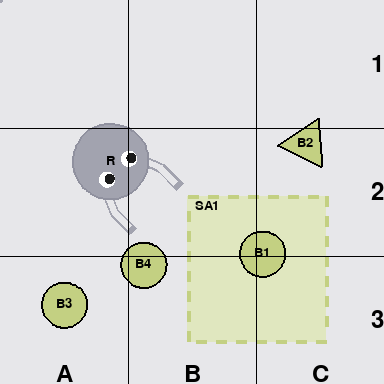
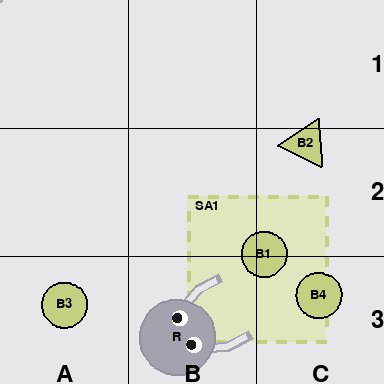
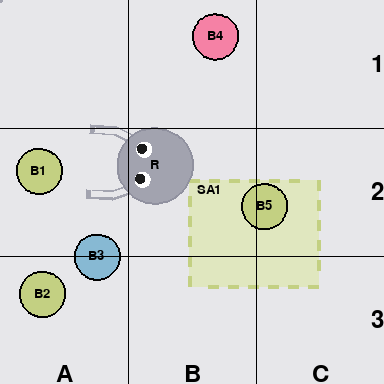
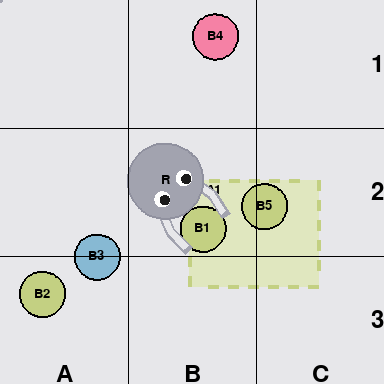
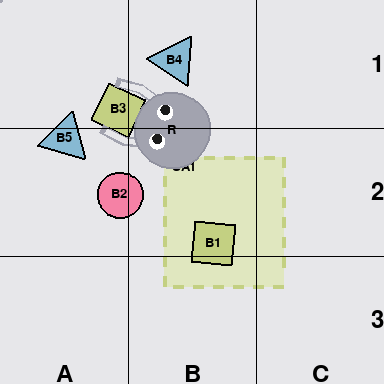
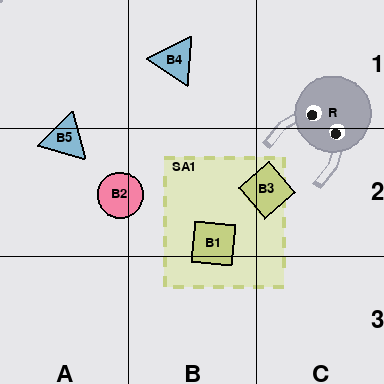
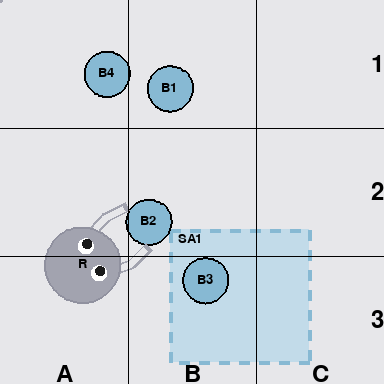
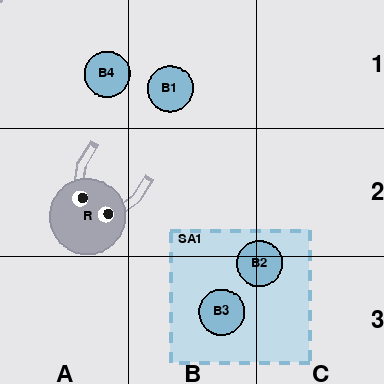
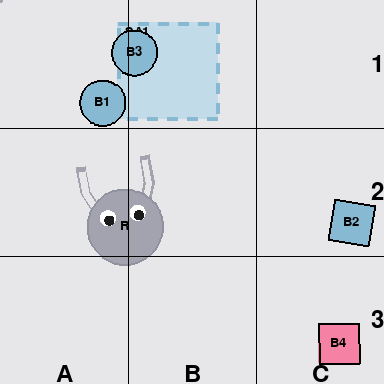
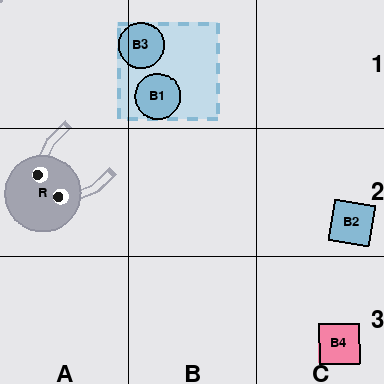
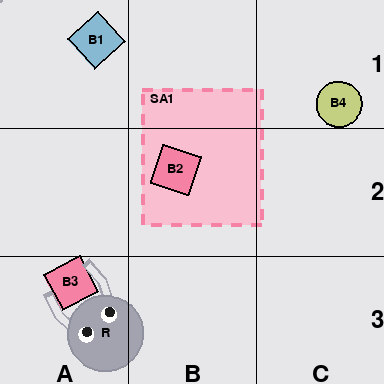
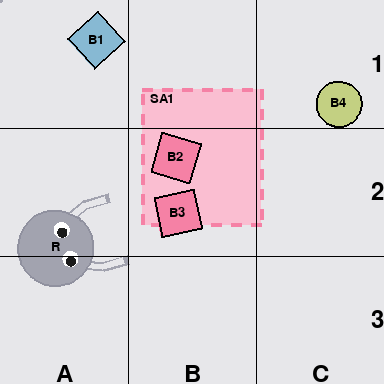
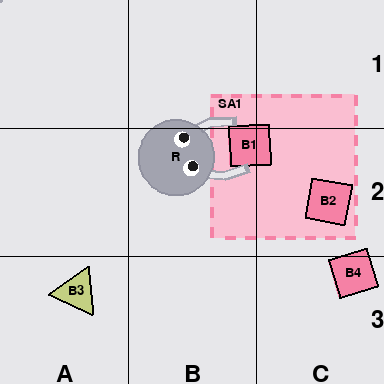
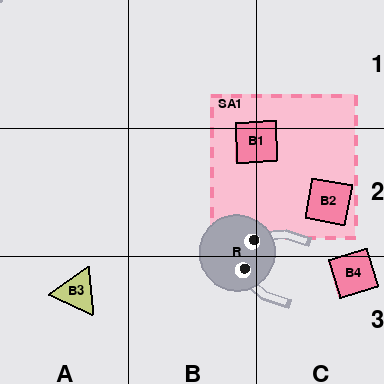
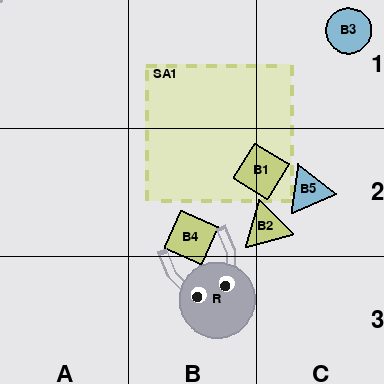
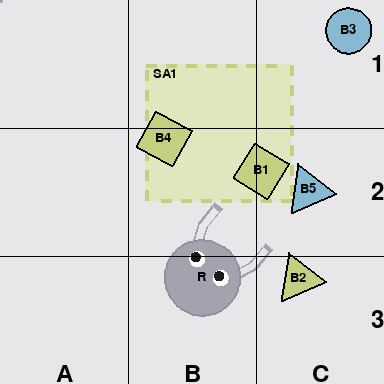
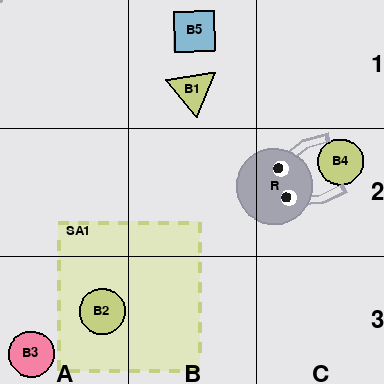
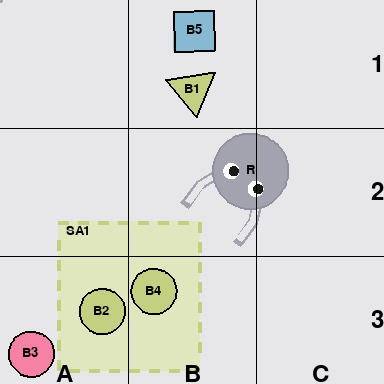
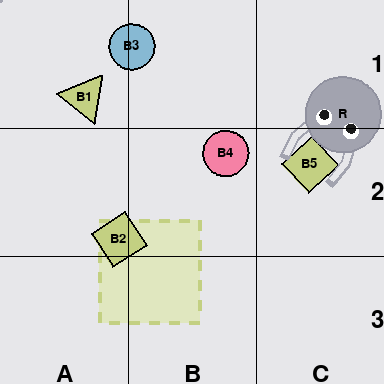
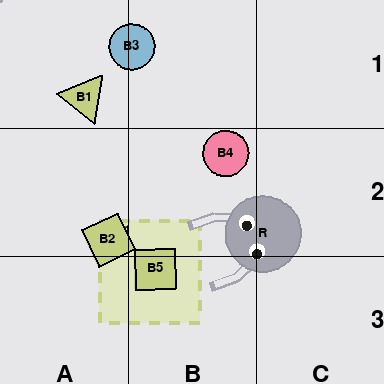

In [192]:
import glob
# SET WHAT TASK and FRAME PAIRS TO USE 
frame_pairs_dir = '/Users/alexandrasouly/code/chai/magical/frame_pairs'
task_num = 'Task2'
frame_pairs = '20-frame-pairs'

# SET WHAT PROMPT template to use
prompt_template = 'two_frame_short_goal'


### Don't need to edit these ###
task_folder = os.path.join(frame_pairs_dir, task_num, frame_pairs)
ground_truth_file = os.path.join(task_folder,'alex_ground_truth.json')
assert os.path.isdir(task_folder), f"{task_folder} is not a folder that exists"
# folders inside task_folder of the form pair1, pair2, pair3, etc.
img_pair_folders = [folder for folder in os.listdir(task_folder) if folder.startswith('pair')]
pair_num = {int(fold.split('pair')[-1]):fold for fold in img_pair_folders}
sorted_folders = [pair_num[key] for key in sorted(pair_num.keys())]
assert len(sorted_folders)==10

answers = []
for img_pair_folder in sorted_folders:
    traj_folder = os.path.join(task_folder, img_pair_folder)
    output_folder = os.path.join(task_folder, img_pair_folder, prompt_template)
    resolution = 'high'
    # pick images inside traj_folder
    images =glob.glob(f'{traj_folder}/*.png')
    frames = {int(img.split('-')[-1].split('.')[0]):img for img in images}
    sorted_images = [frames[key] for key in sorted(frames.keys())]
    ans_file = main(traj_folder, output_folder, prompt_template, resolution, sorted_images)
    answers.append(ans_file)

write_final_answer(prompt_template, ground_truth_file, task_folder, answers)
    